<a href="https://colab.research.google.com/github/vjhawar12/Vision-Transformer-paper-implementation/blob/main/notebook/Vision_Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

### 📌 **Quick Start:**
If you just want to test the pretrained model without training:

👉 Scroll down to **"🔍 Load Pretrained Model and Evaluate on CIFAR-10 Test Set"**

Before that:

- ✅ **Clone the GitHub repository**
- ✅ **Import the necessary modules**
- ✅ **Load the training hyperparameters**



#Cloning Repo

In [ ]:
!git clone https://github.com/vjhawar12/Vision-Transformer-paper-implementation.git
%cd Vision-Transformer-paper-implementation

#  Importing libraries

In [ ]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from vit.dataloader import get_dataloaders
from vit.scheduler_func import sched_func
from vit.transforms import get_transforms
from vit.train_utils import train, validate
from vit.test_utils import test
from torchvision.transforms.v2 import CutMix, MixUp, RandomChoice
from vit.vit_model import PatchEmbedding, ManualMultiHeadSelfAttention, TransformerEncoder, VisionTransformer
from vit.data import data
from vit.dataset import get_training_data, get_test_data
from timm.loss import SoftTargetCrossEntropy
from torch.optim.lr_scheduler import LambdaLR
from pprint import pprint

# Loading hyperparameters

In [ ]:
with open("hyperparams.json", "r") as f:
    params = json.load(f)
    pprint(params)

{'alpha': 0.25,
 'batchsize': 512,
 'channels': 3,
 'cutmix_or_mixup_start': 20,
 'dropout': 0.05,
 'embeddim': 252,
 'encoders': 8,
 'epochs': 100,
 'imsize': 64,
 'max_cutmix_or_mixup': 0.5,
 'max_mixup': 0.5,
 'mixup_bias': 0.7,
 'mixup_start': 10,
 'numclasses': 10,
 'numheads': 12,
 'patchsize': 4}


# Variable initialization

In [ ]:
train_transform, test_transform = get_transforms()

training_data = get_training_data(train_transform)
test_data = get_test_data(test_transform)

In [ ]:
train_dataloader, test_dataloader = get_dataloaders(training_data, test_data, params['batchsize'])

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
sft_loss_fn = SoftTargetCrossEntropy()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.amp.GradScaler()

cutmix = CutMix(num_classes=params['numclasses'])
mixup = MixUp(num_classes=params['numclasses'], alpha=params['alpha'])

# CUDA optimizations

In [ ]:
if torch.cuda.is_available():
  torch.backends.cuda.matmul.allow_tf32 = True
  torch.backends.cudnn.allow_tf32 = True
  torch.backends.cuda.enable_flash_sdp(True)
  torch.backends.cuda.enable_mem_efficient_sdp(True)
  torch.backends.cuda.enable_math_sdp(True)

# Model creation

In [ ]:
vit = torch.compile(VisionTransformer(
    batches=params['batchsize'], in_channels=params['channels'],
    patch_size=params['patchsize'], embed_dim=params['embeddim'],
    heads=params['numheads'], depth=params['encoders'], size=params['imsize'],
    num_classes=params['numclasses']
  ))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

In [ ]:
optim = torch.optim.AdamW(vit.parameters(), lr=1e-3, weight_decay=0.05)
scheduler = LambdaLR(optim, lr_lambda=sched_func)

# Train and validation set loop

In [ ]:
train_acc = []
val_acc = []
lr = []
losses = []

for i in range(params['epochs']):
    torch.cuda.empty_cache()
    vit.train(True)

    loop = tqdm(train_dataloader, desc=f"Epoch {i+1}/{params['epochs']}", leave=True, disable=False)

    total, correct, loss = train(
        vit, device, params['cutmix_or_mixup_start'],
        params['mixup_start'], params['max_cutmix_or_mixup'],
        params['max_mixup'], optim, mixup, cutmix,
        sft_loss_fn, loss_fn, scaler, i, loop,
    )

    val_total, val_correct = validate(vit, test_dataloader, device)

    val_accuracy = val_correct / val_total
    accuracy = correct / total

    scheduler.step()
    current_lr = optim.param_groups[0]['lr']

    losses.append(loss)
    lr.append(current_lr)
    train_acc.append(accuracy)
    val_acc.append(val_accuracy)

    print(f"Epoch {i + 1}: LR={current_lr:.6f} \t Train Acc: {accuracy:.4f} \t Val Acc: {val_accuracy:.4f}")

# Test set loop

In [ ]:
vit.eval()
correct, total = test(vit, test_dataloader, device)
accuracy = correct / total

print(f"Accuracy: {accuracy}")

Accuracy: 0.8588


# Per-epoch loss graph

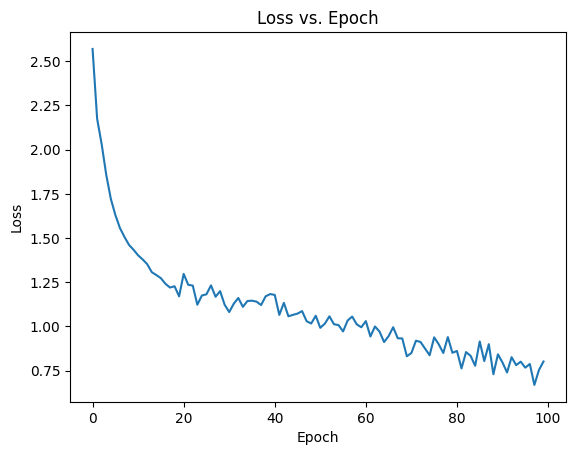

In [ ]:
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.plot(losses)

# Per-epoch LR graph

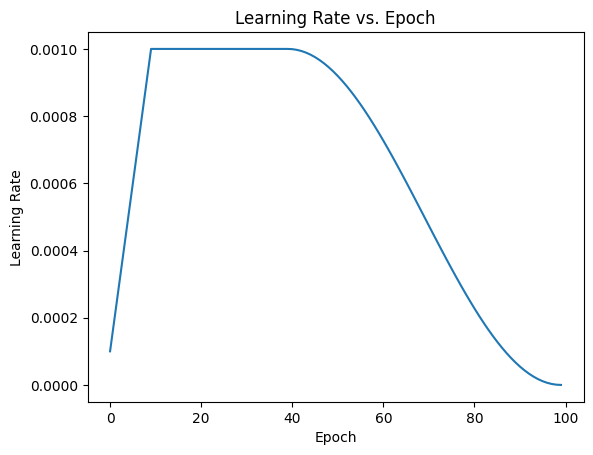

In [ ]:
plt.title("Learning Rate vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

plt.plot(lr)

# Per-epoch Training vs Validation set accuracy graph

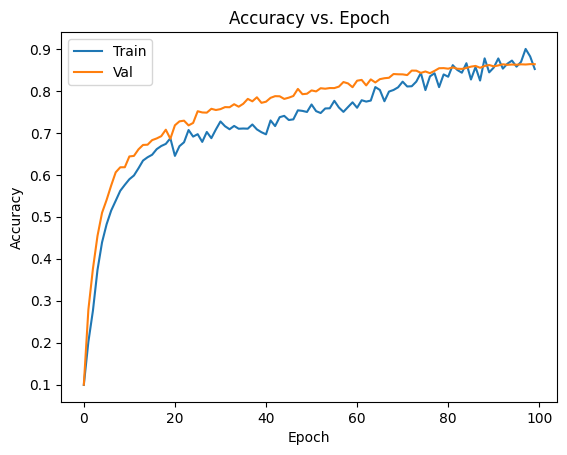

In [ ]:
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Val")

plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")


plt.legend()

# Data table

In [ ]:
df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10
Trial #,1,2,3,4,5,6,7,8,9,10,11
Image size,32,32,32,32,32,32,32,64,64,64,64
Embedding dimension,384,384,384,192,192,192,192,252,252,252,252
Number of heads,12,12,12,12,12,8,8,12,12,12,12
Number of encoders,8,8,8,8,8,8,6,8,8,8,12
Batch size,128,128,128,128,128,128,128,128,128,512,512
Epochs,20,20,50,30,30,30,30,100,100,100,100
Patch size,4,4,4,4,8,4,4,4,4,4,4
Optimizer,SGD,Adam,SGD,AdamW,AdamW,AdamW,AdamW,AdamW,AdamW,AdamW,AdamW
Learning rate,0.001,0.001,0.1,0.0003,0.0003,0.0003,3e-4 with 1e-5 weight decay,0.003 with 0.05 weight decay,0.003 with 0.05 weight decay,0.003 with 0.05 weight decay,0.003 with 0.05 weight decay


## 📊 Final Results

- **Dataset**: CIFAR-10
- **Model**: Vision Transformer (ViT)
- **Paper**: [An Image is Worth 16x16 Words (Dosovitskiy et al.)](https://arxiv.org/abs/2010.11929)
- **Training Epochs**: 100
- **Batch Size**: 512  
- **Optimizer**: AdamW  
- **Accelerator**: NVIDIA A100 GPU
- **Learning Rate**: 0.003 with 0.05 weight decay
- **Train Accuracy**: 87.2%
- **Test Accuracy**: 85.9%



# Load pre-trained model and evaluate on CIFAR-10



In [ ]:
model = VisionTransformer(
    batches=params['batchsize'], in_channels=params['channels'],
    patch_size=params['patchsize'], embed_dim=params['embeddim'],
    heads=params['numheads'], depth=params['encoders'], size=params['imsize'],
    num_classes=params['numclasses']
  )


url = "https://huggingface.co/vjhawar12/vit-cifar10/resolve/main/vit_cifar10.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
state_dict = torch.hub.load_state_dict_from_url(url, map_location=device)
state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model.eval()

In [ ]:
train_transform, test_transform = get_transforms()
train_data = get_training_data(train_transform)
test_data = get_test_data(test_transform)

train_transform, test_dataloader = get_dataloaders(train_data, test_data, params['batchsize'])

correct, total = test(model, test_dataloader, device)
accuracy = correct / total

print(f"Accuracy: {accuracy}")


100%|██████████| 170M/170M [00:01<00:00, 86.2MB/s]


Accuracy: 0.8588
